In [1]:
# Import packages

import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Part C

Diffusion model for sklearn digits

In [2]:
# Load digits
digits = load_digits()
X = digits.images.astype(np.float32)  # shape (n, 8, 8)

# Normalize to [-1,1]
X = (X - X.min()) / (X.max() - X.min())
X = X * 2 - 1

# Add channel (n,1,8,8)
X = torch.tensor(X).unsqueeze(1)

print(X.shape)


torch.Size([1797, 1, 8, 8])


In [3]:
def timestep_embedding(t, dim):
    half = dim // 2
    device = t.device

    freqs = torch.exp(
        -np.log(10000) * torch.arange(0, half, dtype=torch.float32, device=device) / half
    )

    args = t[:, None].float() * freqs[None]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)


In [4]:
class UNet(nn.Module):
    def __init__(self, channels=1, emb_dim=32):
        super().__init__()

        self.conv1 = nn.Conv2d(channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, channels, 3, padding=1)

        self.time_mlp = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, x, t):
        emb = timestep_embedding(t, 32).to(x.device)
        emb = self.time_mlp(emb)
        emb = emb[:, :, None, None]  # reshape for broadcasting

        h = torch.relu(self.conv1(x))
        h = h + emb
        h = torch.relu(self.conv2(h))
        h = torch.relu(self.conv3(h))
        out = self.conv4(h)
        return out


In [5]:
T = 300  # fewer steps for 8x8, works great
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1 - betas
alphas_cum = torch.cumprod(alphas, dim=0)

sqrt_ac = torch.sqrt(alphas_cum)
sqrt_one_minus_ac = torch.sqrt(1 - alphas_cum)

# move to gpu
betas = betas.to(device)
alphas = alphas.to(device)
alphas_cum = alphas_cum.to(device)
sqrt_ac = sqrt_ac.to(device)
sqrt_one_minus_ac = sqrt_one_minus_ac.to(device)



In [6]:
def q_sample(x0, t):
    noise = torch.randn_like(x0)
    ac = sqrt_ac[t].view(-1, 1, 1, 1)
    om = sqrt_one_minus_ac[t].view(-1, 1, 1, 1)
    return ac * x0 + om * noise, noise


In [7]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

X_gpu = X.to(device)
n = len(X)

batch_size = 128
epochs = 25000

print("Training DDPM...")
loss_history = {}
for step in range(epochs):
    idx = torch.randint(0, n, (batch_size,))
    x0 = X_gpu[idx]

    t = torch.randint(0, T, (batch_size,), device=device).long()
    xt, noise = q_sample(x0, t)

    pred_noise = model(xt, t)
    loss = loss_fn(pred_noise, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 300 == 0:
        loss_history[step] = loss.item()
        print(step, loss.item())


Training DDPM...
0 1.022169589996338
300 0.24126693606376648
600 0.21350181102752686
900 0.2426852583885193
1200 0.18011474609375
1500 0.16936764121055603
1800 0.195656418800354
2100 0.18861502408981323
2400 0.19083711504936218
2700 0.19858193397521973
3000 0.1880551278591156
3300 0.17917996644973755
3600 0.19130471348762512
3900 0.16706475615501404
4200 0.1658015102148056
4500 0.16360780596733093
4800 0.19569364190101624
5100 0.18433359265327454
5400 0.1619371771812439
5700 0.16971951723098755
6000 0.18462269008159637
6300 0.17508061230182648
6600 0.14879830181598663
6900 0.17473772168159485
7200 0.16402064263820648
7500 0.1651480495929718
7800 0.16601496934890747
8100 0.1628979593515396
8400 0.1800304651260376
8700 0.17840632796287537
9000 0.156209796667099
9300 0.17318195104599
9600 0.17859110236167908
9900 0.18165850639343262
10200 0.17420357465744019
10500 0.1687544882297516
10800 0.1759837418794632
11100 0.15497750043869019
11400 0.17170169949531555
11700 0.16510191559791565
1200

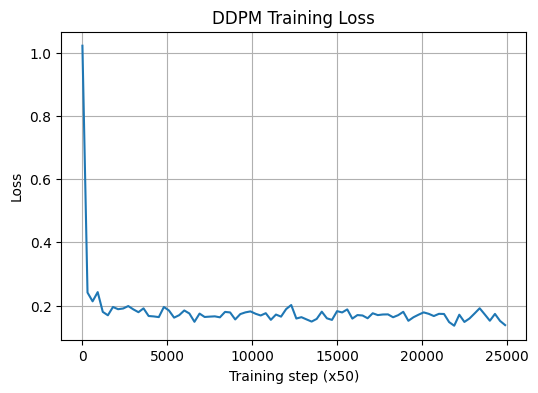

In [10]:
plt.figure(figsize=(6,4))
plt.plot(loss_history.keys(),loss_history.values())
plt.title("DDPM Training Loss")
plt.xlabel("Training step (x50)")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [11]:
@torch.no_grad()
def sample_ddpm(n_samples=20):
    x = torch.randn((n_samples, 1, 8, 8), device=device)

    for t in reversed(range(T)):
        t_tensor = torch.full((n_samples,), t, device=device).long()
        noise_pred = model(x, t_tensor)

        alpha = alphas[t]
        ac = alphas_cum[t]

        x = (1 / torch.sqrt(alpha)) * (x - (1 - alpha) / torch.sqrt(1 - ac) * noise_pred)

        if t > 0:
            noise = torch.randn_like(x)
            x += torch.sqrt(betas[t]) * noise

    return x


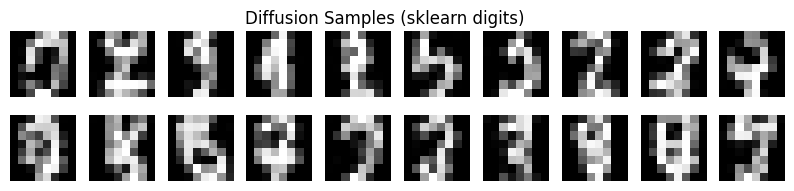

In [12]:
samples = sample_ddpm(20).cpu()

samples = (samples + 1) / 2
samples = samples.clamp(0, 1)

fig, axes = plt.subplots(2, 10, figsize=(10,2))
for ax, img in zip(axes.flatten(), samples):
    ax.imshow(img[0], cmap='gray')
    ax.axis("off")

plt.suptitle("Diffusion Samples (sklearn digits)")
plt.show()
